In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [108]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer, wordpunct_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.corpus import words

In [67]:
import re

In [68]:
pd.options.mode.chained_assignment = None  # default='warn'

## Data Cleaning

In [69]:
df = pd.read_csv("../data/combined.csv")
initial_df = df
df.head()

,all_awardings,associated_award,author,author_flair_background_color,author_flair_css_class,author_flair_template_id,author_flair_text,author_flair_text_color,awarders,body,...,treatment_tags,author_flair_richtext,author_flair_type,author_fullname,author_patreon_flair,author_premium,author_cakeday,distinguished,edited,steward_reports
0,[],NaN,[deleted],NaN,NaN,NaN,NaN,dark,[],[removed],...,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[],NaN,[deleted],NaN,NaN,NaN,NaN,dark,[],[removed],...,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[],NaN,[deleted],NaN,NaN,NaN,NaN,dark,[],[removed],...,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[],NaN,dumpsterworm,NaN,sung,ecc6ea06-1ac9-11e4-b0ce-12313d090e7a,NaN,dark,[],"Actually, I hadn't heard about that, and it is...",...,[],[],text,t2_dzbvzge,False,False,NaN,NaN,NaN,NaN
4,[],NaN,[deleted],NaN,NaN,NaN,NaN,dark,[],[removed],...,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
df.isna().sum()

all_awardings                         0
associated_award                   2200
author                                0
author_flair_background_color      2200
author_flair_css_class             2087
author_flair_template_id           2140
author_flair_text                  2200
author_flair_text_color            1807
awarders                              0
body                                  0
collapsed_because_crowd_control    2200
comment_type                       2200
created_utc                           0
gildings                              0
id                                    0
is_submitter                          0
link_id                               0
locked                                0
no_follow                             0
parent_id                             0
permalink                             0
retrieved_on                          0
score                                 0
send_replies                          0
stickied                              0


In [71]:
df.dtypes

all_awardings                       object
associated_award                   float64
author                              object
author_flair_background_color      float64
author_flair_css_class              object
author_flair_template_id            object
author_flair_text                  float64
author_flair_text_color             object
awarders                            object
body                                object
collapsed_because_crowd_control    float64
comment_type                       float64
created_utc                          int64
gildings                            object
id                                  object
is_submitter                          bool
link_id                             object
locked                                bool
no_follow                             bool
parent_id                           object
permalink                           object
retrieved_on                         int64
score                                int64
send_replie

In [72]:
len(set(df['id']))

2200

In [73]:
# Keeping only body and target column
df = df[['body','subreddit', 'score', 'id']]
df

,body,subreddit,score,id
0,[removed],communism,0,g98roj8
1,[removed],communism,1,g98uc83
2,[removed],communism,1,g98ul9u
3,"Actually, I hadn't heard about that, and it is...",communism,1,g98v0je
4,[removed],communism,1,g98vr5q
...,...,...,...,...
2195,Tell him to put a sign on his door saying “fre...,Capitalism,1,fbho51q
2196,Without getting into a masters thesis on price...,Capitalism,1,fbhsc7h
2197,In my experience with pricing individual produ...,Capitalism,1,fbhtp3t
2198,One possibility is the effect of marketing and...,Capitalism,1,fbhwyys


In [74]:
df.rename(columns={"subreddit": "sub_class"}, inplace=True)

In [75]:
set(df['sub_class'])

{'Capitalism', 'communism'}

In [76]:
# Subreddit column modify to have binary classification
# Mapping 'Capitalism' : 1 , and 'communism': 0

df.loc[:,'sub_class'] = df['sub_class'].apply(lambda x : 1 if x == 'Capitalism' else 0)
df['sub_class'].value_counts()

1    1100
0    1100
Name: sub_class, dtype: int64

In [77]:
# body containing: '[removed]' needs to be treated like nan
df['body'] = df['body'].apply(lambda x : None if x == '[removed]' else x)
df

,body,sub_class,score,id
0,None,0,0,g98roj8
1,None,0,1,g98uc83
2,None,0,1,g98ul9u
3,"Actually, I hadn't heard about that, and it is...",0,1,g98v0je
4,None,0,1,g98vr5q
...,...,...,...,...
2195,Tell him to put a sign on his door saying “fre...,1,1,fbho51q
2196,Without getting into a masters thesis on price...,1,1,fbhsc7h
2197,In my experience with pricing individual produ...,1,1,fbhtp3t
2198,One possibility is the effect of marketing and...,1,1,fbhwyys


In [78]:
df.isna().sum()

body         247
sub_class      0
score          0
id             0
dtype: int64

In [79]:
df = df.dropna()

In [80]:
df['sub_class'].value_counts(normalize=True)

1    0.543779
0    0.456221
Name: sub_class, dtype: float64

In [81]:
df.isna().sum()

body         0
sub_class    0
score        0
id           0
dtype: int64

In [82]:
df.tail()

,body,sub_class,score,id
2195,Tell him to put a sign on his door saying “fre...,1,1,fbho51q
2196,Without getting into a masters thesis on price...,1,1,fbhsc7h
2197,In my experience with pricing individual produ...,1,1,fbhtp3t
2198,One possibility is the effect of marketing and...,1,1,fbhwyys
2199,A company as large and savvy as McDonalds is a...,1,1,fbhx0bv


## EDA + Feature Engineering

- Before performing EDA it's important to add columns that can give us some text metrics of the text body


In [83]:
temp_df = df.copy()

In [84]:
# Reference for regex expression for matching all words
# including the words with apostrophe
# [Source]: https://stackoverflow.com/questions/36190267/match-words-with-hyphens-and-apostrophes?rq=1
tokenizer = RegexpTokenizer("'?\w[\w']*(?:-\w+)*'?")
tokenizer_char = RegexpTokenizer(".")

df.loc[:,'word_count'] = df['body'].apply(lambda x: len(tokenizer.tokenize(x))).copy()
df.loc[:,'count_char'] = df['body'].apply(lambda x: len(tokenizer_char.tokenize(x))).copy()

In [85]:
df.head()

,body,sub_class,score,id,word_count,count_char
3,"Actually, I hadn't heard about that, and it is...",0,1,g98v0je,25,141
5,"No offense to the OP, but no one really knows ...",0,2,g98w052,142,816
6,None taken. I wasn’t expecting a silver bullet...,0,1,g98wloj,53,295
7,"Oh ok, thanks, now its just left to learn to m...",0,-1,g98x32f,39,187
9,what lol all I said is you should probably mak...,0,2,g98xoru,84,449


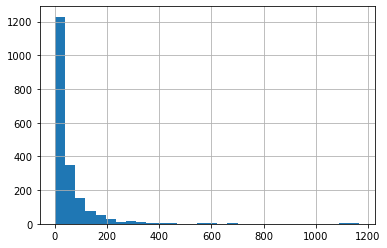

In [86]:
# Examine dist of both 'word_count' and 'count_char'
df['word_count'].hist(bins=30);

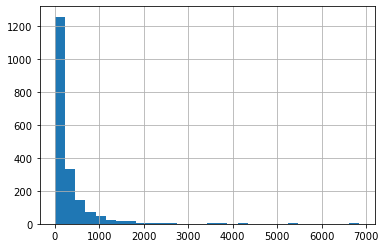

In [87]:
df['count_char'].hist(bins=30);

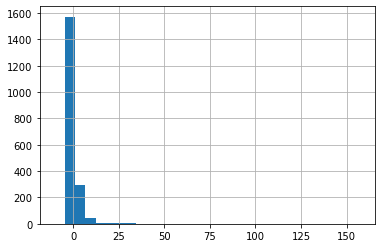

In [88]:
df['score'].hist(bins=30);

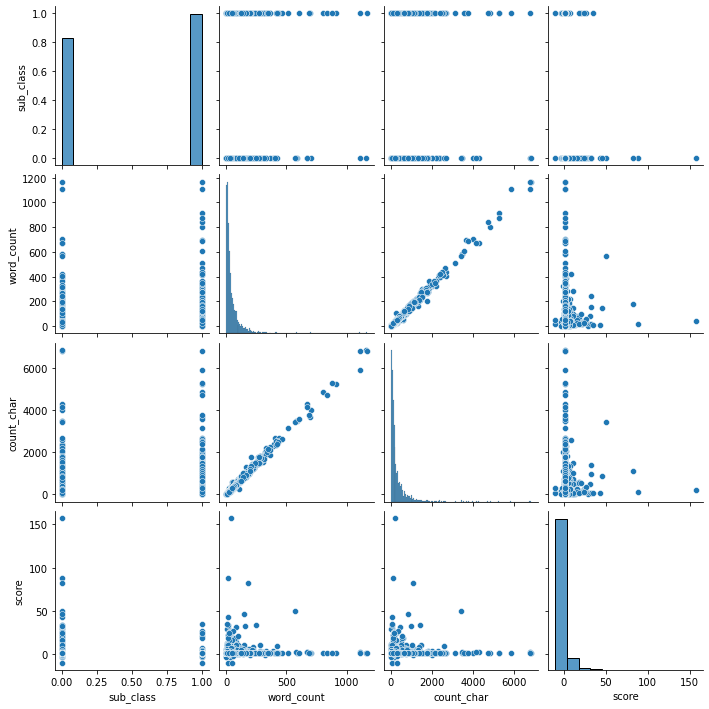

In [89]:
# Pairplot of subreddit, word_count, count_char
sns.pairplot(df[['sub_class', 'word_count', 'count_char','score']]);

- `word_count`, `count_char` and `score` appear to be higly skewed to the right, so performing a log tranform can give us a better 

In [90]:
# Sqrt transfromations:
# Because the data we want to tranform contains 0, sqrt can give us a 
# [Source]: https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45

df.loc[:,'word_count_sqrt'] = np.sqrt(df['word_count'].copy())
df.loc[:,'count_char_sqrt'] = np.sqrt(df['count_char'].copy())

In [91]:
df.describe()

,sub_class,score,word_count,count_char,word_count_sqrt,count_char_sqrt
count,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000,1953.000000
mean,0.543779,2.034818,54.991807,322.658986,6.092416,14.705426
std,0.498207,5.715221,97.362603,573.136963,4.228880,10.318136
min,0.000000,-10.000000,0.000000,1.000000,0.000000,1.000000
25%,0.000000,1.000000,11.000000,64.000000,3.316625,8.000000
50%,1.000000,1.000000,26.000000,145.000000,5.099020,12.041595
75%,1.000000,1.000000,60.000000,352.000000,7.745967,18.761663
max,1.000000,157.000000,1167.000000,6844.000000,34.161382,82.728472


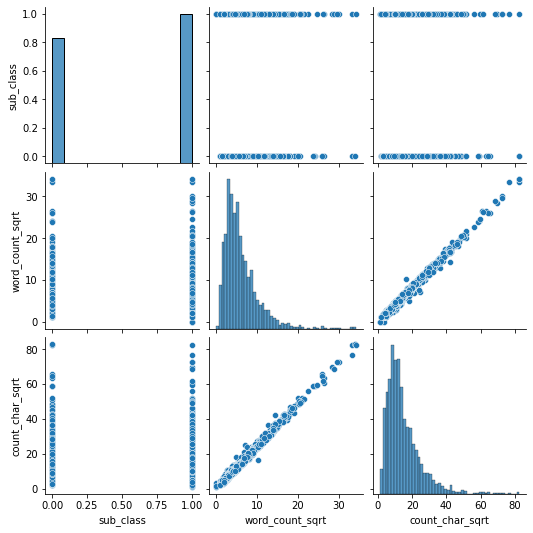

In [92]:
sns.pairplot(df[['sub_class', 'word_count_sqrt', 'count_char_sqrt']]);

## EDA on Vectorized text

In [93]:
url_regex = "(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})"

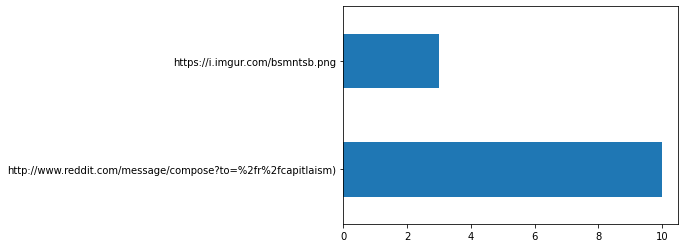

In [94]:
cvec_url = CountVectorizer(stop_words='english', token_pattern=url_regex, min_df=3)
cvec_url.fit(df['body'])
body_cv = cvec_url.transform(df['body'])
body_df = pd.DataFrame(body_cv.todense(), columns=cvec_url.get_feature_names())
top_25 = body_df.sum().sort_values(ascending=False).head(25)
body_df.sum().sort_values(ascending=False).head(15).plot(kind='barh');

In [125]:
# Remove URLs from body, after seeing that URLs don't seem to have common high counts
regex_nums = "[0-9]+"
def my_ref_filter(string):
    result = re.sub(url_regex, '', string)
    return result


In [126]:
df.loc[:, 'body'] = df['body'].apply(my_ref_filter).copy()

In [129]:
final_stopwords_list = stopwords.words('english') + stopwords.words('russian') 

In [130]:
cvec = CountVectorizer(stop_words= final_stopwords_list, min_df=2)

In [131]:
cvec.fit(df['body'])
body_cv = cvec.transform(df['body'])
body_df = pd.DataFrame(body_cv.todense(), columns=cvec.get_feature_names())
top_25 = body_df.sum().sort_values(ascending=False).head(25)


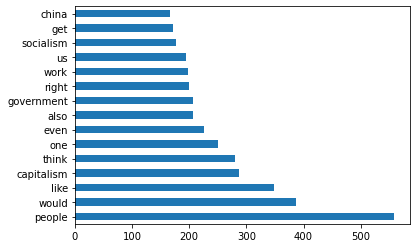

In [132]:
body_df.sum().sort_values(ascending=False).head(15).plot(kind='barh');

In [133]:
body_df.head()

,abandon,abide,ability,able,abroad,absence,absolute,absolutely,abstract,absurd,...,yacht,yea,yeah,year,yep,yes,yet,york,young,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
body_df.shape

(1953, 3094)

In [135]:
df.head()

,body,sub_class,score,id,word_count,count_char,word_count_sqrt,count_char_sqrt
3,"Actually , I ' t about that , and it is extrem...",0,1,g98v0je,25,141,5.000000,11.874342
5,"No offense to the , but no one really for cert...",0,2,g98w052,142,816,11.916375,28.565714
6,None taken . I ’ t a silver bullet solution . ...,0,1,g98wloj,53,295,7.280110,17.175564
7,"Oh , thanks , now its just left to learn to ma...",0,-1,g98x32f,39,187,6.244998,13.674794
9,what all I said is you should probably make th...,0,2,g98xoru,84,449,9.165151,21.189620


In [136]:
df.columns

Index(['body', 'sub_class', 'score', 'id', 'word_count', 'count_char',
       'word_count_sqrt', 'count_char_sqrt'],
      dtype='object')

In [137]:
df.shape

(1953, 8)

In [138]:
# IMPORTNAT ! **RESETIING INDEX**
test = df.reset_index(drop=True)

In [139]:
vect_plus_org = pd.concat([test, body_df], axis=1)
vect_plus_org.head(1)

,body,sub_class,score,id,word_count,count_char,word_count_sqrt,count_char_sqrt,abandon,abide,...,yacht,yea,yeah,year,yep,yes,yet,york,young,zero
0,"Actually , I ' t about that , and it is extrem...",0,1,g98v0je,25,141,5.0,11.874342,0,0,...,0,0,0,0,0,0,0,0,0,0


## EDA on VADER

In [140]:
corpus = list(df['body'])
id_corpus = list(df['id'])
sia = SentimentIntensityAnalyzer()

In [141]:
# create dataframe that contains text and the polarity scores for each tweet
# Reference taken from EC_local_flex exercie
dicts = []    
counter = 0
for text in corpus:
    scores = sia.polarity_scores(text)
    scores['body'] = text
    scores['id'] = id_corpus[counter]
    dicts.append(scores)
    counter+=1
df_vader = pd.DataFrame(dicts)
df_vader.head()

,neg,neu,pos,compound,body,id
0,0.088,0.773,0.140,0.2967,"Actually , I ' t about that , and it is extrem...",g98v0je
1,0.155,0.725,0.120,-0.6457,"No offense to the , but no one really for cert...",g98w052
2,0.000,0.941,0.059,0.3182,None taken . I ’ t a silver bullet solution . ...,g98wloj
3,0.239,0.679,0.082,-0.6771,"Oh , thanks , now its just left to learn to ma...",g98x32f
4,0.045,0.800,0.155,0.8014,what all I said is you should probably make th...,g98xoru


In [50]:
df_vader.columns

Index(['neg', 'neu', 'pos', 'compound', 'body', 'id'], dtype='object')

In [44]:
print(f'Shape df: {df.shape}')
print(f'Shape body_df: {body_df.shape}')
print(f'Shape df_vader: {df_vader.shape}')

Shape df: (1953, 8)
Shape body_df: (1953, 3173)
Shape df_vader: (1953, 6)


In [45]:
len(set(df['id']))

1953

In [46]:
len(set(df_vader['id']))

1953

In [47]:
merged = vect_plus_org.merge(df_vader, on='id')
merged = merged.drop(columns=['body_y'])
merged = merged.rename(columns={"body_x": "body"})
merged.head(1)

,body,sub_class,score,id,word_count,count_char,word_count_sqrt,count_char_sqrt,000,10,...,yes,yet,york,young,youtube,zero,neg,neu,pos,compound
0,"Actually, I hadn't heard about that, and it is...",0,1,g98v0je,25,141,5.0,11.874342,0,0,...,0,0,0,0,0,0,0.078,0.799,0.124,0.2967


### Export dataset used for modeling


In [48]:
#merged.to_csv('../data/data_modeling.csv', index=False)